In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T
from torchvision import models
from torchvision.datasets import ImageFolder

import warnings

import kornia as K

```
dataset
|- classes.json
|- images
|  |- img0001.jpg
|  |- img0002.jpg
|  |  ...
|  `- img000N.jpg
`- masks
   |- img0001.jpg
   |- img0002.jpg
   |  ...
   `- img000N.jpg
```

In [2]:
import json
import os
import shutil


def _safe_create(path, replace, allowed):
    ''' safely creates directories
        if path already exists either replace or ignore
    '''
    path_exists = os.path.isdir(path)
    if path_exists and not allowed:
        return -1  # fail
    if path_exists and allowed and not replace:
        return 0  # success
    if path_exists and replace:
        shutil.rmtree(path)  # delete content and folder
        os.mkdir(path)  # recreate folder
        os.path.exist
        return 0
    if not path_exists:
        os.mkdir(path)
        return 0


def safe_create(path, replace=False, allowed=True):
    ''' outer definition with error handling '''
    try:
        status = _safe_create(path, replace, allowed)
    except FileExistsError as fee:
        status = -2
    except FileNotFoundError as fnf:
        status = -3
    except Exception as e:
        status = 1
        errstr = e.__str__
        
    if status != 0:
        raise EnvironmentError('failed to create folder, with error {}'.format({
             1: 'other error: {}'.format(errstr),
            -1: 'path already existed and this is not allowed',
            -2: 'path already existed and didn''t failed to deal with this',
            -3: 'parent directory doesn''t exist'}[status]))


def _generate_dataset(path, reload=True, masks=False, is_valid_file=lambda _: True, transforms=None):
    with open(os.path.join(path, 'classes.json'), 'r') as fid:
        classes = json.load(fid)
        
    loader_dir = os.path.join(path, '_loadable')
    safe_create(loader_dir, replace=reload)
    
    for name, label in classes.items():
        labeldir = os.path.join(loader_dir, str(label))
        safe_create(labeldir, replace=False, allowed=True)
        shutil.copyfile(
            os.path.join(path, 'masks' if masks else 'images', name),
            os.path.join(labeldir, name))
    return ImageFolder(
        root=loader_dir,
        is_valid_file=is_valid_file,
        transform=transforms)

def generate_dataset(path, reload=False, masks=False, nattempts=2, is_valid_file=lambda _: True, transforms=None):
    try:
        return _generate_dataset(path, reload=reload, masks=masks, is_valid_file=is_valid_file, transforms=transforms)
    except Exception as e:
        loader_dir = os.path.join(path, '_loadable')
        if os.path.isdir(loader_dir):
            shutil.rmtree(loader_dir)
        if nattempts > 0:
            return generate_dataset(path, reload=reload, masks=masks, nattempts=nattempts-1, is_valid_file=is_valid_file, transforms=transforms)
        else:
            print('tried and failed to create dataset {} times'.format(nattempts))
            raise e

In [3]:
is_valid_file = lambda name: (os.path.splitext(name)[-1] == '.jpg')

class ExtractPatchUnfold:
    def __init__(self, nb_patches=10):
        self.nb_patches=nb_patches
        
    def __call__(self, x):
        dim = 0
        x = torch.repeat_interleave(x.unsqueeze(dim), repeats=self.nb_patches, dim=dim)
        return K.augmentation.ImageSequential(
            K.augmentation.RandomCrop((128, 128)),
            same_on_batch=False)(x)
        

transforms = T.Compose([ # takes in PIL image by default
    T.CenterCrop((1024,1024)),
    T.ToTensor(),
    ExtractPatchUnfold(9),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = generate_dataset('../tmp/demo/', is_valid_file=is_valid_file, transforms=transforms)

In [4]:
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [8]:
len(dataset_loader.dataset.classes)

3

In [175]:
batch_data, batch_class = next(iter(dataset_loader))

In [176]:
batch_data.shape

torch.Size([10, 9, 3, 128, 128])

In [177]:
batch_class

tensor([2, 0, 0, 0, 0, 0, 1, 0, 1, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


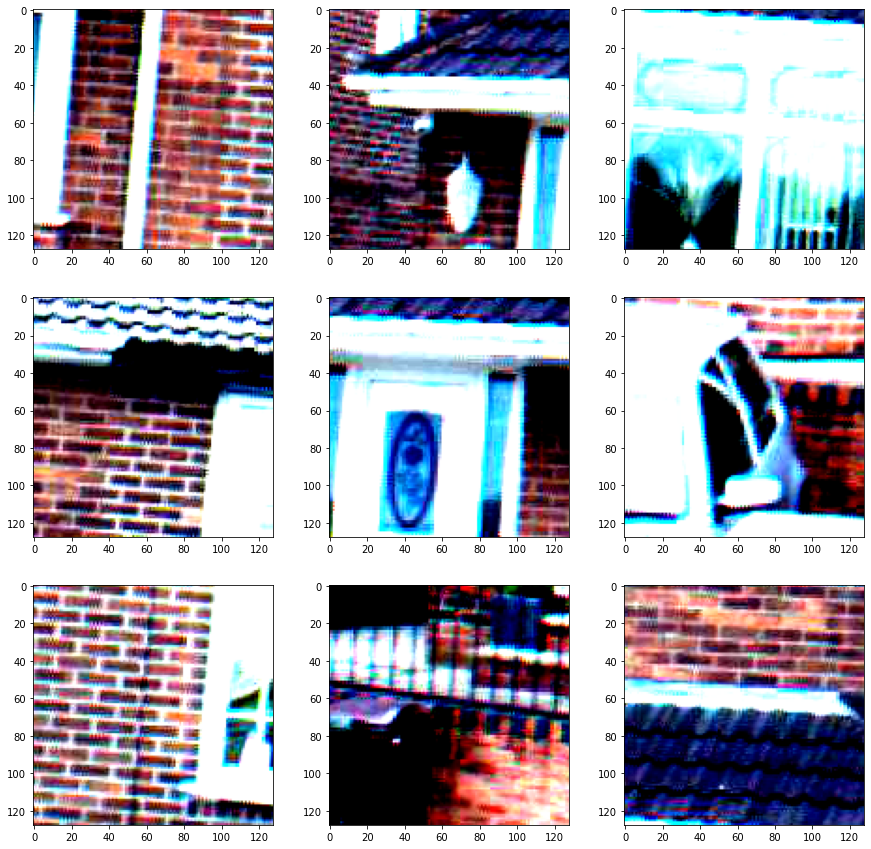

In [167]:
for i_batch, sample in enumerate(dataset_loader):
    _, axs = plt.subplots(3,3,figsize=(15,15))
    for i in range(9):
        axs.ravel()[i].imshow(np.transpose(np.asarray(sample[0])[0,i,:,:,:],[1,2,0]))
    break

In [168]:
class CombinePredictions(torch.nn.Module):
    """ Custom module to combine predictions of patches from batch patchnet"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        ''' maybe correct this if mean is not appropriate 
            
            essentially averages class predictions for specific patches to create single guess
        '''
        return torch.mean(x, axis=-2)
    

class AgeDetector(torch.nn.Module):
    def __init__(
        self,
        numclasses = 7,
        backbone = torchvision.models.resnet18,
        pretrained = False,
        fixbackbone = False):
        """ this uses a segmentation-based backbone to calculate age of patches """
        super().__init__()
        self._numclasses  = numclasses
        self._pretrained  = pretrained
        self._fixbackbone = fixbackbone
        self._generate_backbone(backbone)
        self._generate_outlayer()
        self._generate_prediction_layer()
        
        
    def _generate_backbone(self, backbone):
        ''' creates backbone network '''
        if self._fixbackbone and not self._pretrained:
            warnings.warning('fix_backbone requested so enabling pretrained weights by default')
        self._backbone = models.resnet18(pretrained=(self._pretrained or self._fixbackbone))
        self._backbone_out_features = self._backbone.fc.in_features
        if self._fixbackbone:
            for param in self._backbone.parameters():
                param.requires_grad = False


    def _generate_outlayer(self):
        ''' creates output layer for classification '''
        self._backbone.fc = torch.nn.Linear(self._backbone_out_features, self._numclasses)


    def _generate_prediction_layer(self):
        ''' create softmax prediction layer '''
        self._predict = CombinePredictions()

        
    def forward(self, x):
        ''' forward transform '''
        in_shape = x.shape
        nb_batch, nb_patch = in_shape[0], in_shape[1]
        
        x =  torch.flatten(x, start_dim=0, end_dim=1)
        x = self._backbone(x)
        x = torch.reshape(x, (nb_batch, nb_patch, -1))
        x = self._predict(x)
        return x

In [169]:
model = AgeDetector(3)

model.eval()
with torch.no_grad():
    input_batch, label = iter(dataset_loader).next()
    output = model(input_batch)

In [171]:
output.shape

torch.Size([10, 3])

In [111]:
type(models.resnet18)

function

In [116]:
model.modules()

TypeError: 'generator' object is not subscriptable

In [119]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [126]:
torch.nn.MaxPool1d(kernel_size=9)(output).shape

TypeError: _MaxPoolNd.__init__() got an unexpected keyword argument 'axis'

In [144]:
input_batch = torch.randn(20, 10, 3, 128, 128)

mid_batch = torch.flatten(input_batch, start_dim=0, end_dim=1)

out_batch = torch.reshape(mid_batch, input_batch.shape)



torch.Size([20, 10, 3, 128, 128])

In [145]:
torch.all(out_batch == input_batch)

tensor(True)

In [133]:
CombinePredictions()(output).shape

torch.Size([1000])

ValueError: not enough values to unpack (expected 2, got 1)